In [ ]:
# THIS IS NO LONGER UP TO DATE. SEE graham server for script
# - missing Windows library so ScDataset and nemointerp can't be done here. 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import cmocean
import os
import datetime as dt
import scipy.io as sio
import glob
#from scDataset import scDataset
#from nemointerp import build_matrix, use_matrix
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

from salishsea_tools import evaltools as et
import matplotlib.gridspec as gridspec
from scipy.stats import zscore
import scipy
import math

In [109]:
# HRDPS - 2016 - 2019 @ 2.5 km. 
# ERA5 - 1980 - present data @ 30 km
# task - create visuals box around central and northern Strait (mean monthly windspeed, wind rose)
#      - compare ERA5 vs HRDPS
#      - scatter plot for possible regression. wind arrow diagram. wind rose diagram
inpathHRDPS = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//29. Oceanographic Atmospheric//HRDPS//"
inpathERA5 = "C://Users//Greig//Sync//6. SSMSP Model//Model Greig//Data//29. Oceanographic Atmospheric//ECMWF ERA5//adjusted//"

# Coastline
reference = "..//data//reference//"
mfile = sio.loadmat(reference + 'PNW.mat') 
ncst = mfile['ncst']

#example file names: 
# HRDPS_OPPwestSS_ps2.5km_y2016m04d03.nc
# ERA5_SalishSea_fixed_1979.nc or ERA5_SalishSea_fixed_y1979.nc 

# scatter plot

# quiver plot through time

# quiver plot across space (birds-eye-view)

# wind rose

# statistics

year = 2016

def load_data(year):
    f1 = sorted(glob.glob(inpathHRDPS + 'HRDPS_OPPwestSS_ps2.5km_y2016*.nc'))
    #f3 = inpathERA5 + 'ERA5_SalishSea_fixed_y2016.nc'
    f3 = inpathERA5 + 'ERA5_SalishSea_fixed_2016.nc'
    

    return f1, f3

#with nc.Dataset('/home/mid002/WORK4/SalishSea1500/mesh_mask_20210406.nc') as ncf:
#    tmask = ncf.variables['tmask'][0,0,...]   # neglected the 1/2 grid box shift here

f1, f3 = load_data(year)

with nc.Dataset(f1[0]) as ncf:
    hlat = ncf.variables['nav_lat'][...]   # neglected the 1/2 grid box shift here
    hlon = ncf.variables['nav_lon'][...]
        
with nc.Dataset(f3) as ncf:
    elat = ncf['latitude'][...]+0.125    # pcolormesh needs a shift by 1/2 grid box....
    elon = ncf['longitude'][...]+0.125

# can only do scDataset concat on server
#hncf = scDataset(f1)
hncf = nc.Dataset(f1[0])
encf = nc.Dataset(f3)

hu = hncf.variables['u_wind'][0:720,...]
hv = hncf.variables['v_wind'][0:720,...]
eu = encf.variables['u10'][0:720,...]
ev = encf.variables['v10'][0:720,...]

hrdps_ws = np.abs(hu+1j*hv)

In [108]:
hum.data.shape

(256, 251)

<IPython.core.display.Javascript object>


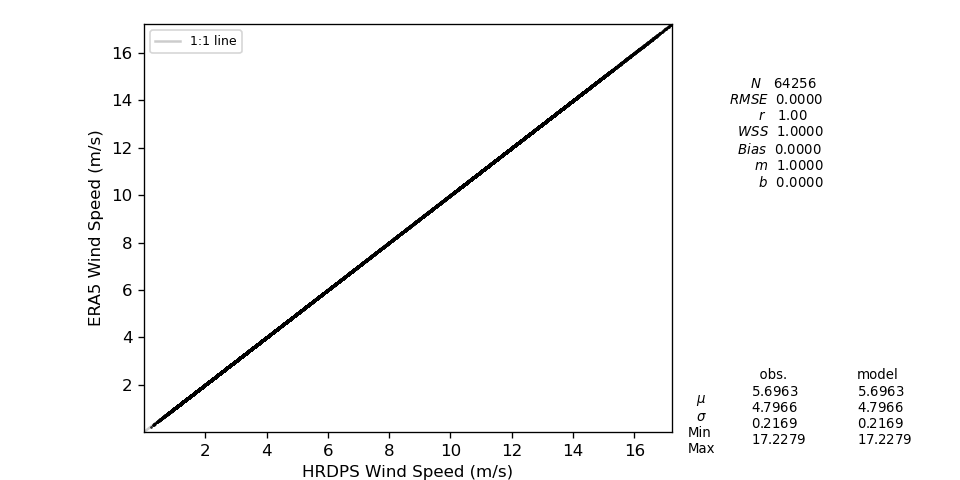

In [69]:
# scatterplot function - produce a panel of plots

def createscatters (fig, ax, data_list, titles_list, xlabels, ylabels, 
                    xscales, yscales, ms, column, numcols, statstext_x,
                    statstext_y, modelobstext_x_list, modelobstext_y_list, zorder):
    j = 0
    axt = [None] * (len(data_list))
    
    for j in range(0,len(data_list),1):
        
        # code to handle final combined figure:
        k = j * numcols + column
        
        # axes limits and line drawn limit based on max values
        maxval = max(np.amax(data_list[j][0]),np.amax(data_list[j][1]))
        minval = min(np.amin(data_list[j][0]),np.amin(data_list[j][1]))
        
        hour = 12
        x = data_list[j][0][hour,:,:]
        y = data_list[j][1][hour,:,:]
        s = data_list[j][2][hour,:,:]
        
        ax[k].plot(x,y,'k.',ms=ms)
        ax[k].set_xlabel(xlabels)
        ax[k].set_ylabel(ylabels)
        ax[k].set_xlim(minval,maxval)
        ax[k].set_ylim(minval,maxval)
        ax[k].set_title(titles_list[j])
        ax[k].set_xscale(xscales)
        ax[k].set_yscale(yscales)
        
#         # summary and skill stats
#         # linear regression expects a long array not wide
        xb = x.reshape(x.shape[0] * x.shape[1]) 
        yb = y.reshape(y.shape[0] * y.shape[1])

        m, b, r_value, p_value, std_err = scipy.stats.linregress(xb, yb)
        ss = np.sum(s)
        rmse = math.sqrt(ss / len(s))
        nobs, minmax_obs, mean_obs, var_obs, skew_obs, kurt_obs = scipy.stats.describe(xb)
        nobs, minmax_mod, mean_mod, var_mod, skew_mod, kurt_mod = scipy.stats.describe(yb)
        stdev_obs = math.sqrt(var_obs)
        stdev_mod = math.sqrt(var_mod)
        pearsons_r, p_val = scipy.stats.pearsonr(xb,yb)
        # MEOPAR tool et.stats, see link above
        nobs, mean_mod2, mean_obs2, bias, rmse2, wss = et.stats(xb,yb)
        
        # 1:1 line:
        ax[k].plot((minval,maxval),(minval,maxval),'k-',alpha=.2,label='1:1 line', zorder=zorder)
        
        # regression line:
#         ax[j].plot(x, m*data_list[j][0] + b, 
#                           label='y={:.2f}x+{:.2f} '.format(m,b))
        # stats text, alignment different in PDF output than screen
    
    
        ax[k].text(statstext_x, statstext_y,
                   # $ = ital., \_ = space within ital
                   "      $N$   {:.0f}".format(nobs) + "\n" +
                   " $RMSE$  {:.4f}".format(rmse) + "\n" +
                   "        $r$   {:.2f}".format(pearsons_r) + "\n" +
                   "   $WSS$  {:.4f}".format(wss) + "\n" +
                   "   $Bias$  {:.4f}".format(bias) + "\n" +
                   "       $m$  {:.4f}".format(m) + "\n" +
                   "        $b$  {:.4f}".format(b),
                   fontsize=8, transform=ax[k].transAxes)
        ax[k].text(modelobstext_x_list[0], modelobstext_y_list[0],
                   "$\ \ \mu$ " + "\n" +
                   "$\ \ \sigma$ " + "\n" +
                   "Min" + "\n" +
                   "Max" + "\n", 
                   fontsize=8, transform=ax[k].transAxes)
        ax[k].text(modelobstext_x_list[1], modelobstext_y_list[1],
                   "  obs." + "\n" + 
                   "${:.4f}$".format(mean_obs) + "\n" +
                   "${:.4f}$".format(stdev_obs) + "\n" +
                   "${:.4f}$".format(minmax_obs[0]) + "\n" +
                   "${:.4f}$".format(minmax_obs[1]),
                   fontsize=8, transform=ax[k].transAxes)
        ax[k].text(modelobstext_x_list[2], modelobstext_y_list[2], 
                   "model" + "\n"
                   "${:.4f}$".format(mean_mod) + "\n" +
                   "${:.4f}$".format(stdev_mod) + "\n" +
                   "${:.4f}$".format(minmax_mod[0]) + "\n" +
                   "${:.4f}$".format(minmax_mod[1]), 
                   fontsize=8, transform=ax[k].transAxes)
        ax[k].legend(fontsize=7.5)
        
        plt.savefig('scatter_hrdsp_vs_ERA5.png')
        
    return fig, ax

# scatter 
rows=1
cols=1

fig1a=plt.figure(figsize=(8,4))
gs = gridspec.GridSpec(rows,cols,left=.15,right=.7,hspace=0.6,wspace=.4,bottom=.1,top=.95)
ax_sp1=list()

for r in range(0,rows,1):
    for c in range(0,cols,1):
        ax_sp1.append(fig1a.add_subplot(gs[r,c]))
ms=1

# the function expects three datasets: observations, model data, difference squared (ss)
modelobs_df = (hrdps_ws-hrdps_ws)**2
data_list_sp1 = [[hrdps_ws,hrdps_ws,modelobs_df]]

# data_list_sp1 = [[modelobs_nooutliers_df[obsvar_col],modelobs_nooutliers_df[modelvar_col],
#                   modelobs_nooutliers_df['ss']]]

titles_list_sp1 = [""]
param = "spatial"
if param == "temporal":
    xlabels_sp1 = "HRDPS Wind Speed (m/s)"
    ylabels_sp1 = "ERA5 Wind Speed (m/s)"
elif param == "spatial":
    xlabels_sp1 = "HRDPS Wind Speed (m/s)"
    ylabels_sp1 = "ERA5 Wind Speed (m/s)"
    
xscales_sp1 = "linear"
yscales_sp1 = "linear"
column = 0
statstext_x = 1.1
statstext_y = 0.6
modelobstext_x_list = [1.03,1.15, 1.35]
modelobstext_y_list = [-0.092,-0.03, -0.03]
zorder = 10

fig1a, ax_sp1 = createscatters(fig1a, ax_sp1, data_list_sp1, titles_list_sp1, xlabels_sp1,
                               ylabels_sp1, xscales_sp1, yscales_sp1, ms, column, cols,
                               statstext_x, statstext_y, modelobstext_x_list, modelobstext_y_list, 
                               zorder)

<IPython.core.display.Javascript object>


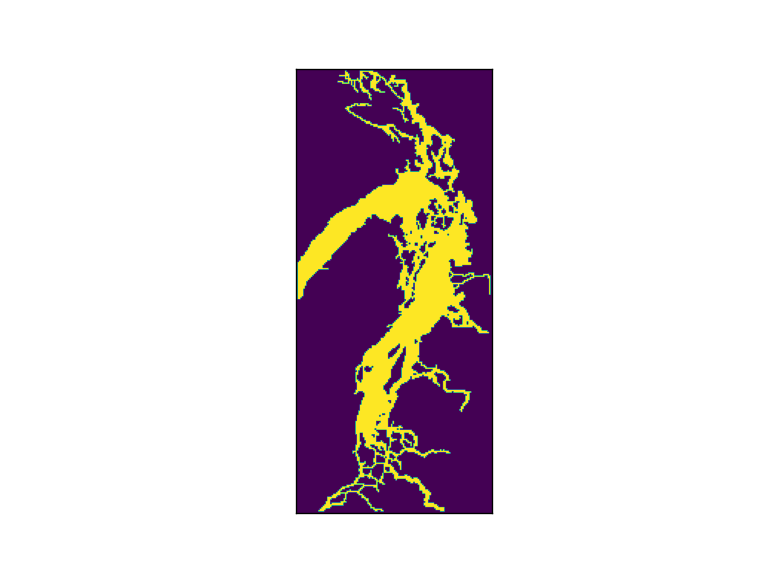

In [2]:
with nc.Dataset('..//data//mesh mask//mesh_mask_20210406.nc') as ncf:
    tmask = ncf.variables['tmask'][0,0,...]   # neglected the 1/2 grid box shift here

fig, ax = plt.subplots()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(tmask)

In [ ]:
# scatter process
# compare all marine values of wind on interpolated NEMO grid (ERA5 / ORAS5)
# try with same dataset


In [15]:
hrdps_wd.shape

(24, 256, 251)

In [20]:

modelobs_df = (hrdps_ws-hrdps_ws)**2

In [27]:
np.amax(hrdps_ws)

17.227873

In [39]:
x

NameError: name 'x' is not defined